In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix,classification_report, f1_score
import seaborn as sns

In [ ]:
def load_data(file_path):
    return pd.read_csv(file_path)

def plot_correlation_matrix(df):
    plt.figure(figsize=(15,10))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
    plt.title("Feature Correlation Matrix", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_pairplot(df, selected_features=None):
    # Use subset of features if provided to avoid clutter
    if selected_features is not None:
        data = df[selected_features]
    else:
        data = df.select_dtypes(include=['number'])  # Default: all numerical
    sns.pairplot(data, diag_kind='hist')
    plt.suptitle("Pair Plot of Selected Features", y=1.02, fontsize=16)
    plt.show()

def plot_histograms(df):
    num_features = df.select_dtypes(include=['number']).columns
    for col in num_features:
        plt.figure(figsize=(6,4))
        plt.hist(df[col], bins=25, color='skyblue', edgecolor='k')
        plt.title(f"Histogram of {col}", fontsize=14)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

def plot_pie_chart(df, target_col):
    if df[target_col].nunique() < 10:
        plt.figure(figsize=(7,7))
        df[target_col].value_counts().plot.pie(
            autopct='%1.1f%%', startangle=90, cmap='Set2', textprops={'fontsize': 12})
        plt.title(f"Class Distribution: {target_col}", fontsize=16)
        plt.ylabel("")
        plt.show()
    else:
        print(f"Pie chart skipped: '{target_col}' has more than 10 unique categories.")


def split_data(df, feature_cols, target_col, test_size=0.2, random_state=42):
    X = df[feature_cols]
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)



def scale_data(X_train, X_test, scaler_type='standard'):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Unsupported scaler_type. Use 'standard', 'minmax', or 'robust'.")

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


def detect_task(y):
    return 'classification' if y.nunique() < 10 and y.dtype != 'float' else 'regression'


def logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return model, preds, acc



def random_forest_clf(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return model, preds, acc



def knn_clf(X_train, y_train, X_test, y_test, k=5):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return model, preds, acc

def grid_search(model, param_grid, X_train, y_train, scoring):
    gs = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    gs.fit(X_train, y_train)
    return gs.best_params_, gs.best_score_


# Gradient Boosting (classification or regression)
def gradient_boosting_classifier(X_train, y_train, X_test, y_test):
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return model,preds,acc




# XGBoost (classification or regression)
def xgboost_classifier(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return model,preds, acc

def xgboost_regressor(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return model,preds, mse


def plot_actual_vs_pred(y_test, preds, title):
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, preds)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def plot_confusion_matrix(y_test, preds, title):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [ ]:
df = load_data("/content/drive/MyDrive/ML DATA SET/fetal_health.csv")


In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [ ]:
df.describe()

baseline value  accelerations  fetal_movement  uterine_contractions  \
count     2126.000000    2126.000000     2126.000000           2126.000000   
mean       133.303857       0.003178        0.009481              0.004366   
std          9.840844       0.003866        0.046666              0.002946   
min        106.000000       0.000000        0.000000              0.000000   
25%        126.000000       0.000000        0.000000              0.002000   
50%        133.000000       0.002000        0.000000              0.004000   
75%        140.000000       0.006000        0.003000              0.007000   
max        160.000000       0.019000        0.481000              0.015000   

       light_decelerations  severe_decelerations  prolongued_decelerations  \
count          2126.000000           2126.000000               2126.000000   
mean              0.001889              0.000003                  0.000159   
std               0.002960              0.000057                  0.000590   
min               0.000000              0.000000                  0.000000   
25%               0.000000              0.000000                  0.000000   
50%               0.000000              0.000000                  0.000000   
75%               0.003000              0.000000                  0.000000   
max               0.015000              0.001000                  0.005000   

       abnormal_short_term_variability  mean_value_of_short_term_variability  \
count                      2126.000000                           2126.000000   
mean                         46.990122                              1.332785   
std                          17.192814                              0.883241   
min                          12.000000                              0.200000   
25%                          32.000000                              0.700000   
50%                          49.000000                              1.200000   
75%                          61.000000                              1.700000   
max                          87.000000                              7.000000   

       percentage_of_time_with_abnormal_long_term_variability  ...  \
count                                         2126.00000       ...   
mean                                             9.84666       ...   
std                                             18.39688       ...   
min                                              0.00000       ...   
25%                                              0.00000       ...   
50%                                              0.00000       ...   
75%                                             11.00000       ...   
max                                             91.00000       ...   

       histogram_min  histogram_max  histogram_number_of_peaks  \
count    2126.000000    2126.000000                2126.000000   
mean       93.579492     164.025400                   4.068203   
std        29.560212      17.944183                   2.949386   
min        50.000000     122.000000                   0.000000   
25%        67.000000     152.000000                   2.000000   
50%        93.000000     162.000000                   3.000000   
75%       120.000000     174.000000                   6.000000   
max       159.000000     238.000000                  18.000000   

       histogram_number_of_zeroes  histogram_mode  histogram_mean  \
count                 2126.000000     2126.000000     2126.000000   
mean                     0.323612      137.452023      134.610536   
std                      0.706059       16.381289       15.593596   
min                      0.000000       60.000000       73.000000   
25%                      0.000000      129.000000      125.000000   
50%                      0.000000      139.000000      136.000000   
75%                      0.000000      148.000000      145.000000   
max                     10.000000      187.000000      182.000000   

       histogram_median  histogr

In [ ]:
df.head()

baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  ...  histogram_min  \
0                                               43.0       ...           62.0   
1                                                0.0       ...           68.0   
2                                                0.0       ...           68.0   
3                                                0.0       ...           53.0   
4                                                0.0       ...           53.0   

   histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  \
0          126.0                        2.0                         0.0   
1          198.0                        6.0                         1.0   
2          198.0                        5.0                         1.0   
3          170.0                       11.0                         0.0   
4          170.0                        9.0                         0.0   

   histogram_mode  histogram_mean  histogram_median  histogram_variance  \
0           120.0           137.0             121.0                73.0   
1           141.0           136.0             140.0                12.0   
2           141.0           135.0             138.0                13.0   
3           137.0           134.0             137.0                13.0   
4           137.0           136.0             138.0                11.0   

   histogram_tendency  fetal_health  
0                 1.0           2.0  
1                 0.0           1.0  
2                 0.0           1.0  
3                 1.0           1.0  
4                 1.0           1.0  

[5 rows x 22 columns]

In [ ]:
all_columns = df.columns.tolist()
print(all_columns)
print(len(all_columns))

['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min', 'histogram_max', 'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance', 'histogram_tendency', 'fetal_health']
22


In [ ]:

feature_cols = ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations',
                'severe_decelerations', 'prolongued_decelerations', 'abnormal_short_term_variability',
                'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability',
                'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min', 'histogram_max',
                'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
                'histogram_median', 'histogram_variance', 'histogram_tendency']       # List your feature columns

target_col = 'fetal_health'

In [ ]:
plot_correlation_matrix(df)


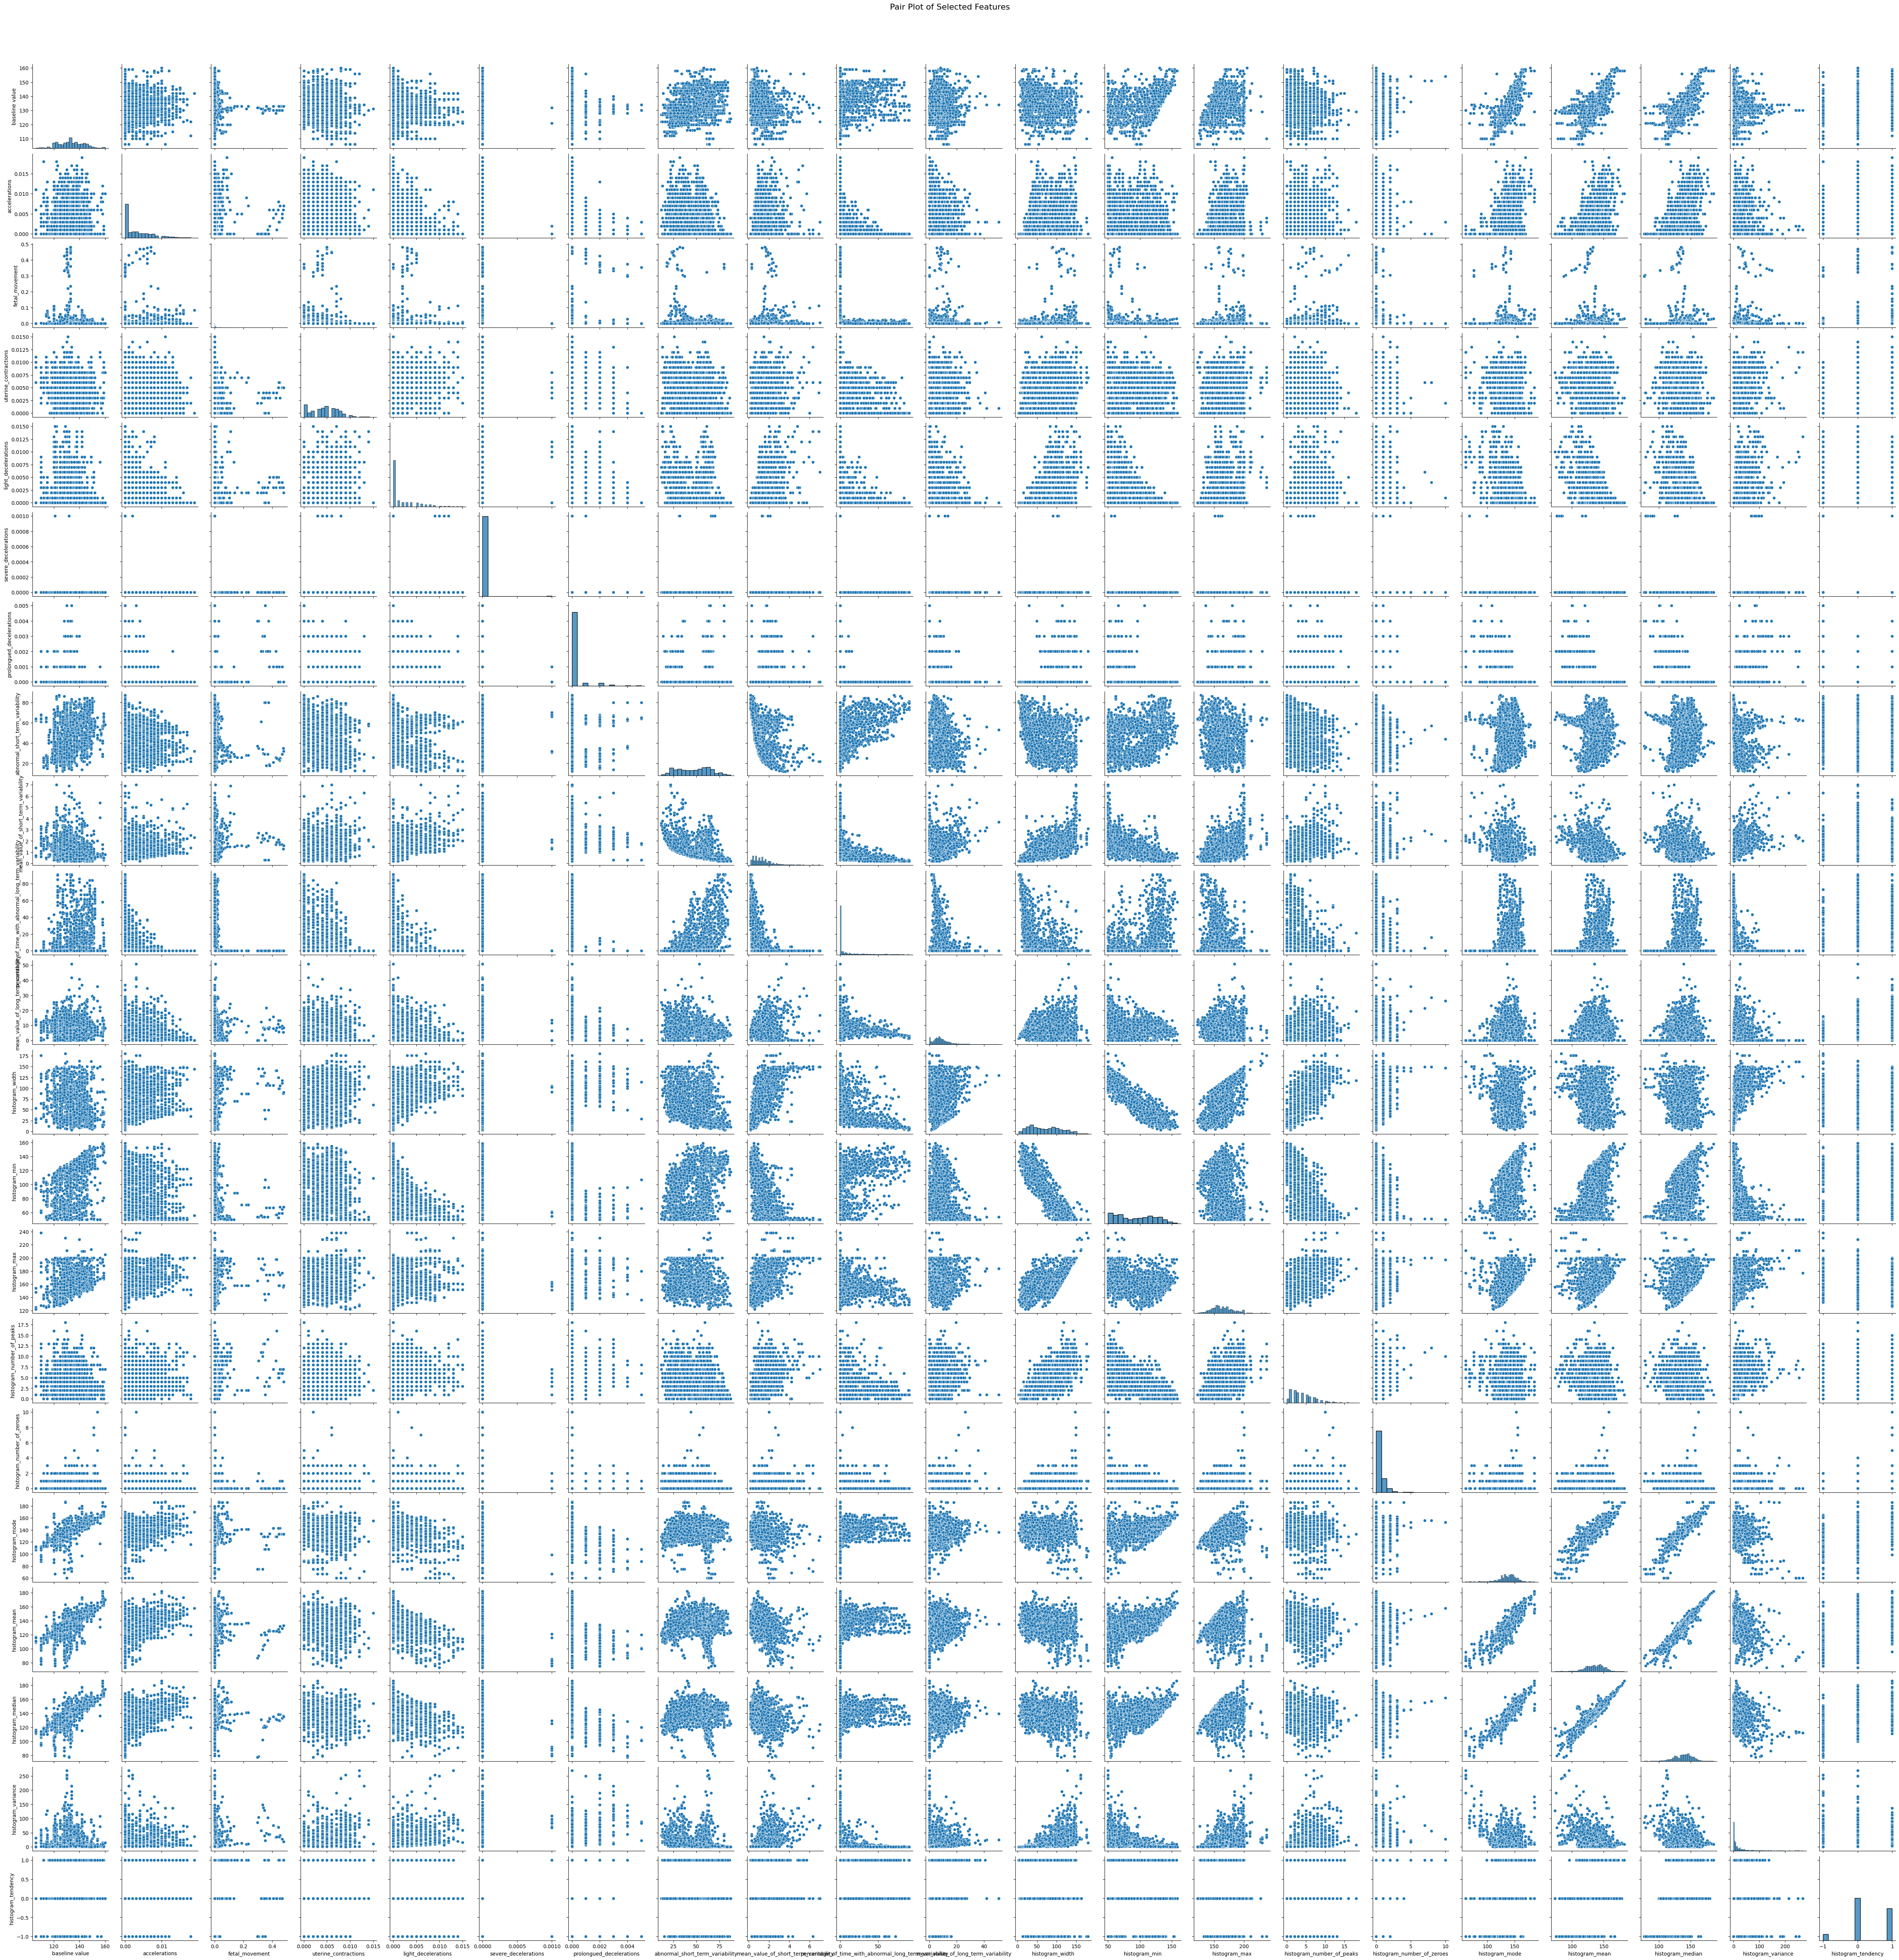

In [ ]:
# Pair plot (optional: specify key features to avoid clutter)
selected_features = ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations',
                'severe_decelerations', 'prolongued_decelerations', 'abnormal_short_term_variability',
                'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability',
                'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min', 'histogram_max',
                'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
                'histogram_median', 'histogram_variance', 'histogram_tendency']  # Replace with actual features
plot_pairplot(df, selected_features)

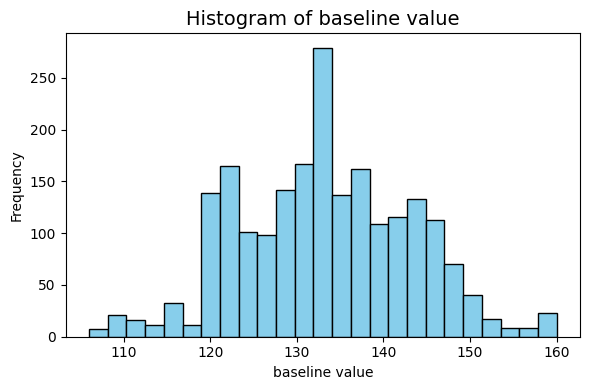

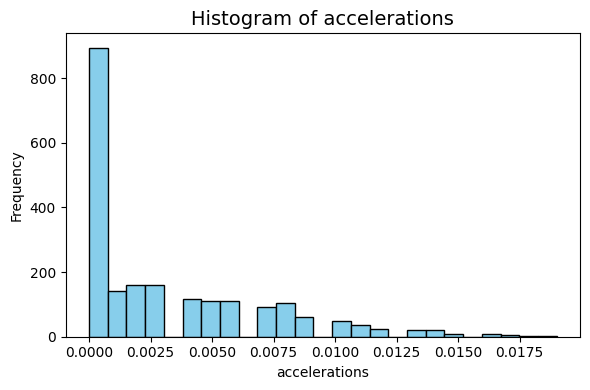

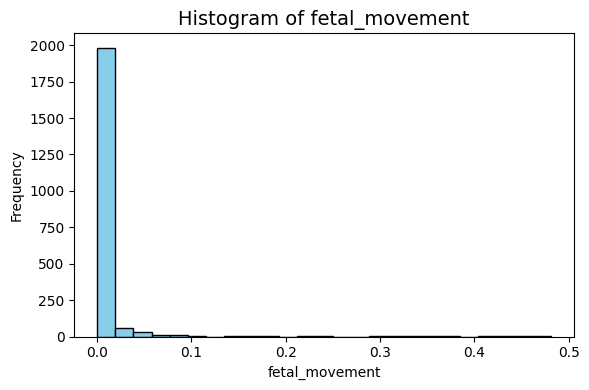

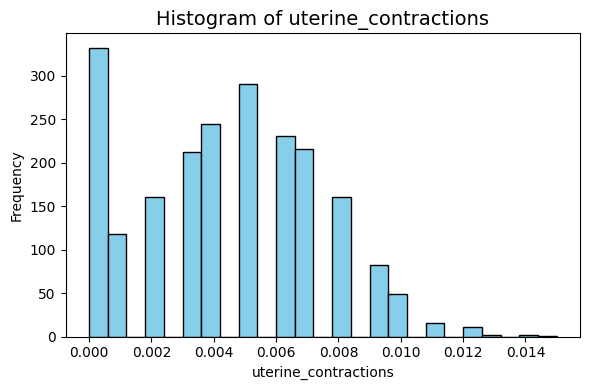

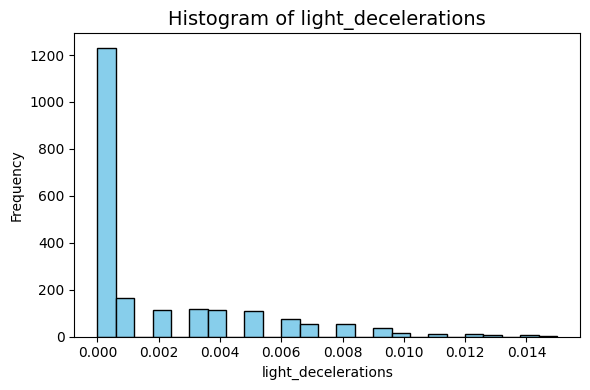

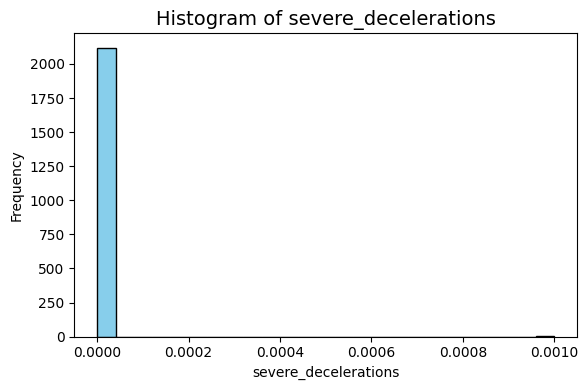

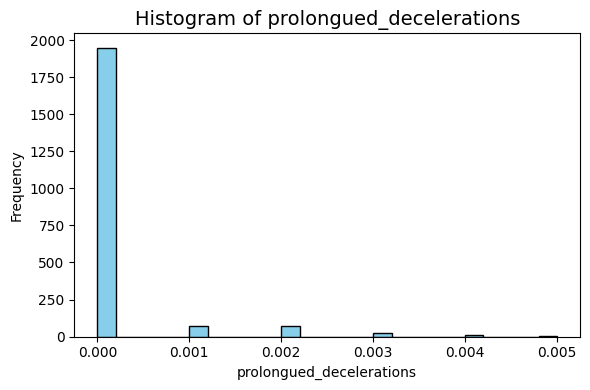

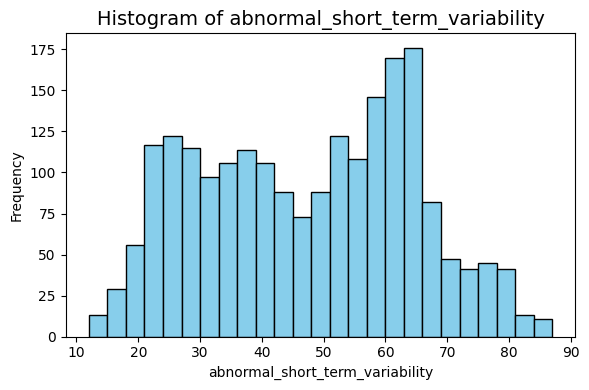

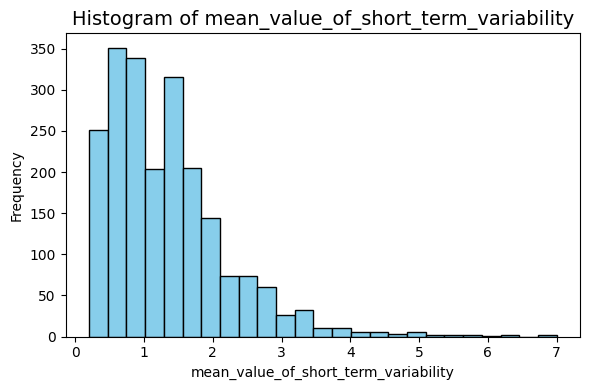

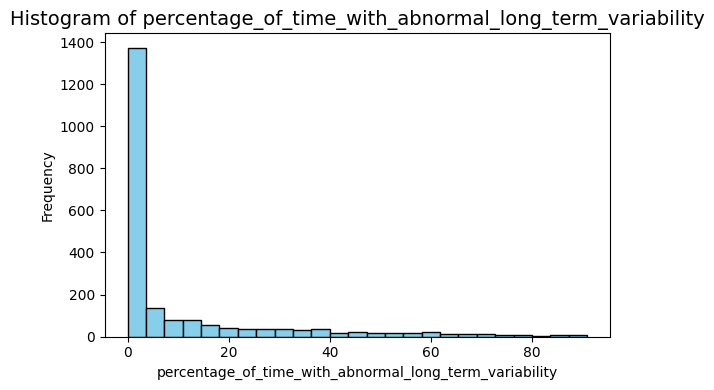

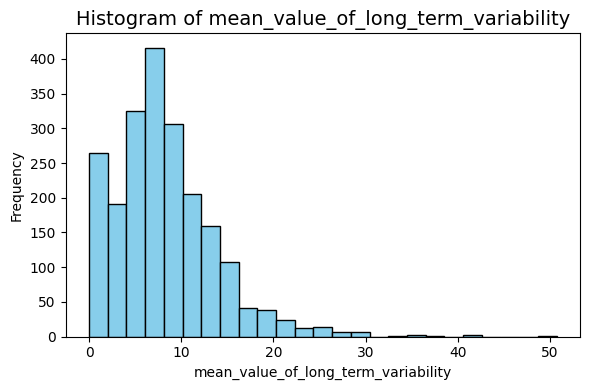

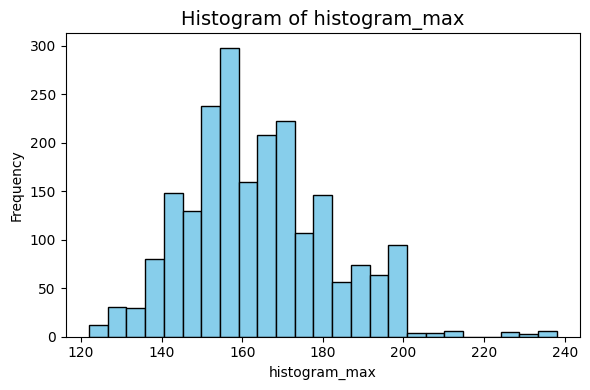

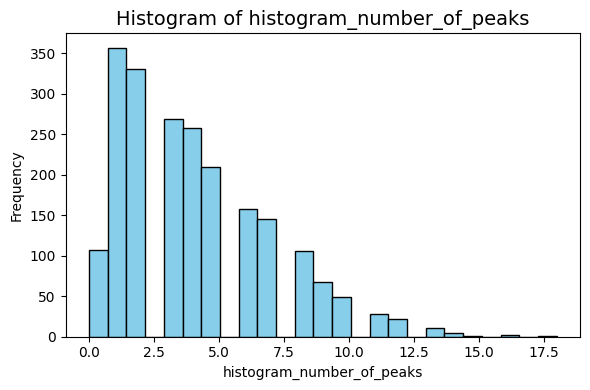

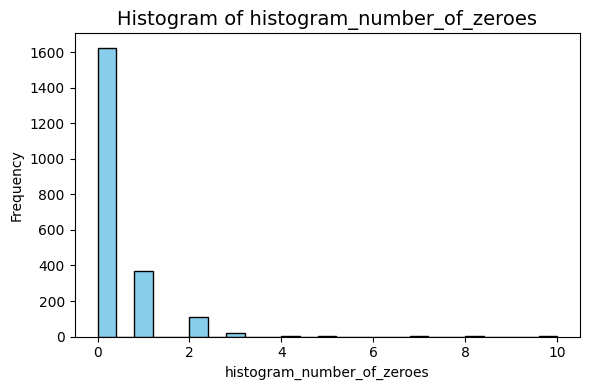

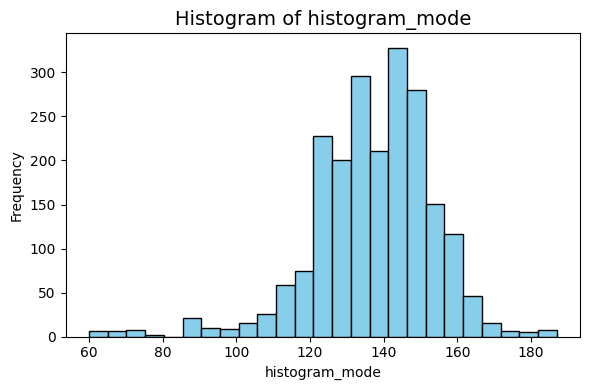

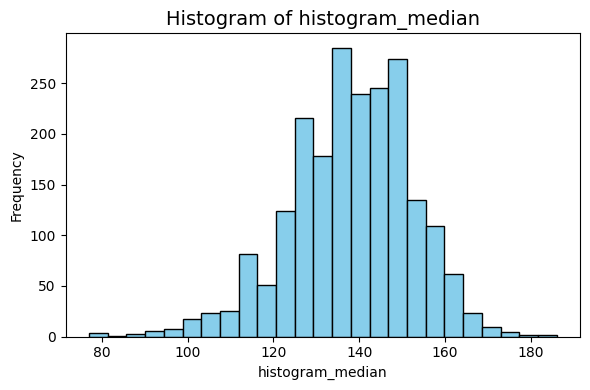

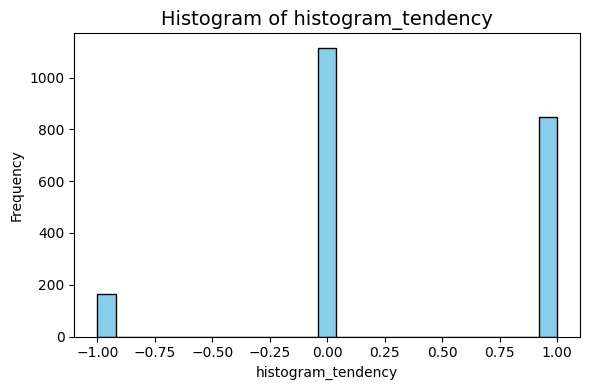

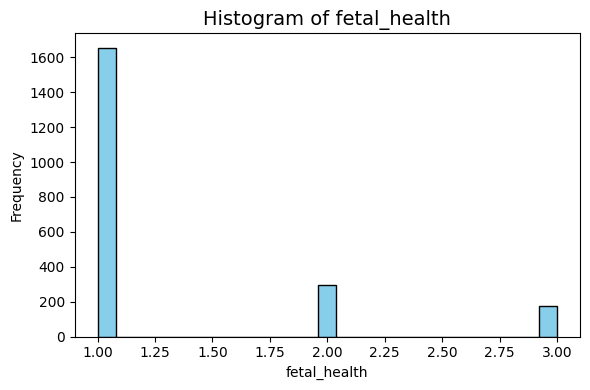

In [ ]:
# Histograms for numeric columns
plot_histograms(df)

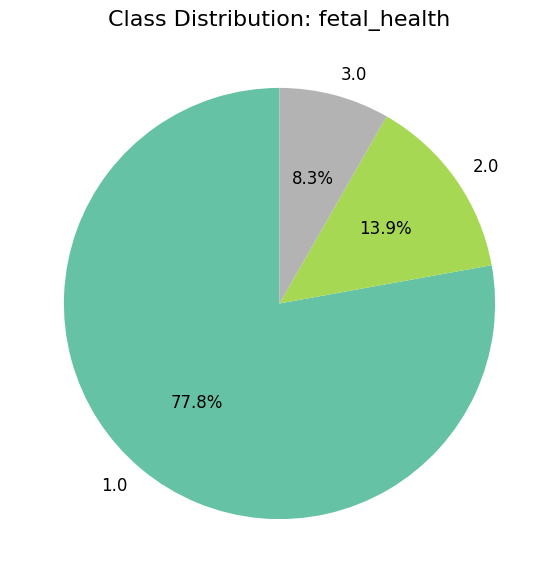

In [ ]:
# Pie chart (only if target is classification with few categories)
plot_pie_chart(df, target_col='fetal_health')

In [ ]:

#Split Data
X_train, X_test, y_train, y_test = split_data(df, feature_cols, target_col)


In [ ]:

# Apply scaling (choose scaler type: 'standard', 'minmax', or 'robust')
X_train_scaled, X_test_scaled = scale_data(X_train, X_test, scaler_type='standard')

In [ ]:
logreg_init = LogisticRegression(max_iter=1000)
logreg_init.fit(X_train_scaled, y_train)
logreg_init_preds = logreg_init.predict(X_test_scaled)
print("Initial Logistic Regression Accuracy:", accuracy_score(y_test, logreg_init_preds))
print(classification_report(y_test, logreg_init_preds))

Initial Logistic Regression Accuracy: 0.8802816901408451
              precision    recall  f1-score   support

         1.0       0.94      0.93      0.94       333
         2.0       0.64      0.66      0.65        64
         3.0       0.76      0.76      0.76        29

    accuracy                           0.88       426
   macro avg       0.78      0.78      0.78       426
weighted avg       0.88      0.88      0.88       426



In [ ]:
# Cross-validation
cv_scores_logreg = cross_val_score(logreg_init, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("CV Scores:", cv_scores_logreg)
print("Mean CV Score: {:.4f}".format(cv_scores_logreg.mean()))

CV Scores: [0.91764706 0.88235294 0.91176471 0.88823529 0.89411765]
Mean CV Score: 0.8988


In [ ]:
# GridSearchCV


logreg = LogisticRegression(max_iter=1000)
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

gs_logreg = GridSearchCV(logreg, logreg_param_grid, scoring='accuracy', cv=5)
gs_logreg.fit(X_train_scaled, y_train)
print("Best LogReg Params:", gs_logreg.best_params_)
print("Best LogReg CV Score:", gs_logreg.best_score_)

Best LogReg Params: {'C': 100, 'solver': 'lbfgs'}
Best LogReg CV Score: 0.9


In [ ]:
# Fit on best parameters
final_logreg = LogisticRegression(**gs_logreg.best_params_, max_iter=1000)
final_logreg.fit(X_train_scaled, y_train)
logreg_preds = final_logreg.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, logreg_preds))
print("Classification Report:\n", classification_report(y_test, logreg_preds))

Test Accuracy: 0.8685446009389671
Classification Report:
               precision    recall  f1-score   support

         1.0       0.94      0.93      0.94       333
         2.0       0.61      0.58      0.59        64
         3.0       0.65      0.76      0.70        29

    accuracy                           0.87       426
   macro avg       0.73      0.76      0.74       426
weighted avg       0.87      0.87      0.87       426



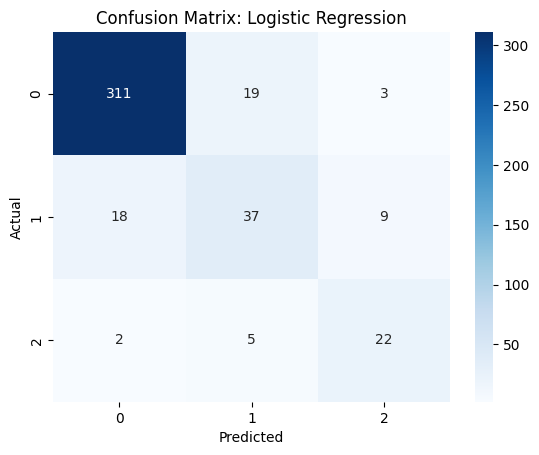

In [ ]:
plot_confusion_matrix(y_test, logreg_preds, title="Confusion Matrix: Logistic Regression")

In [ ]:
# 2. Random Forest
rf_init = RandomForestClassifier()
rf_init.fit(X_train_scaled, y_train)
rf_init_preds = rf_init.predict(X_test_scaled)
print("Initial Random Forest Accuracy:", accuracy_score(y_test, rf_init_preds))
print(classification_report(y_test, rf_init_preds))

Initial Random Forest Accuracy: 0.9530516431924883
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.97       333
         2.0       0.88      0.83      0.85        64
         3.0       0.93      0.93      0.93        29

    accuracy                           0.95       426
   macro avg       0.93      0.91      0.92       426
weighted avg       0.95      0.95      0.95       426



In [ ]:
cv_scores_rf = cross_val_score(rf_init, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("CV Scores:", cv_scores_rf)
print("Mean CV Score: {:.4f}".format(cv_scores_rf.mean()))


CV Scores: [0.93235294 0.92941176 0.92941176 0.93823529 0.95294118]
Mean CV Score: 0.9365


In [ ]:

rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

gs_rf = GridSearchCV(rf, rf_param_grid, scoring='accuracy', cv=5)
gs_rf.fit(X_train_scaled, y_train)
print("Best RF Params:", gs_rf.best_params_)
print("Best RF CV Score:", gs_rf.best_score_)

Best RF Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Best RF CV Score: 0.9382352941176471


In [ ]:
final_rf = RandomForestClassifier(**gs_rf.best_params_)
final_rf.fit(X_train_scaled, y_train)
rf_preds = final_rf.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))


Test Accuracy: 0.9483568075117371
Classification Report:
               precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       333
         2.0       0.89      0.78      0.83        64
         3.0       0.93      0.93      0.93        29

    accuracy                           0.95       426
   macro avg       0.93      0.90      0.91       426
weighted avg       0.95      0.95      0.95       426



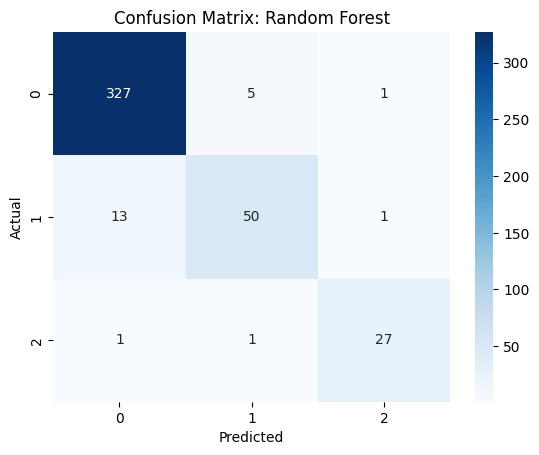

In [ ]:
plot_confusion_matrix(y_test, rf_preds, title="Confusion Matrix: Random Forest")

In [ ]:
# 3. K-Nearest Neighbors
knn_init = KNeighborsClassifier()
knn_init.fit(X_train_scaled, y_train)
knn_init_preds = knn_init.predict(X_test_scaled)
print("Initial KNN Accuracy:", accuracy_score(y_test, knn_init_preds))
print(classification_report(y_test, knn_init_preds))

Initial KNN Accuracy: 0.9154929577464789
              precision    recall  f1-score   support

         1.0       0.94      0.97      0.96       333
         2.0       0.81      0.69      0.75        64
         3.0       0.79      0.76      0.77        29

    accuracy                           0.92       426
   macro avg       0.85      0.81      0.82       426
weighted avg       0.91      0.92      0.91       426



In [ ]:
cv_scores_knn = cross_val_score(knn_init, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("CV Scores:", cv_scores_knn)
print("Mean CV Score: {:.4f}".format(cv_scores_knn.mean()))

CV Scores: [0.89705882 0.88235294 0.88823529 0.88235294 0.91176471]
Mean CV Score: 0.8924


In [ ]:

knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

gs_knn = GridSearchCV(knn, knn_param_grid, scoring='accuracy', cv=5)
gs_knn.fit(X_train_scaled, y_train)
print("Best KNN Params:", gs_knn.best_params_)
print("Best KNN CV Score:", gs_knn.best_score_)

Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best KNN CV Score: 0.9111764705882353


In [ ]:
final_knn = KNeighborsClassifier(**gs_knn.best_params_)
final_knn.fit(X_train_scaled, y_train)
knn_preds = final_knn.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, knn_preds))
print("Classification Report:\n", classification_report(y_test, knn_preds))

Test Accuracy: 0.9272300469483568
Classification Report:
               precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       333
         2.0       0.81      0.73      0.77        64
         3.0       0.86      0.86      0.86        29

    accuracy                           0.93       426
   macro avg       0.88      0.86      0.86       426
weighted avg       0.93      0.93      0.93       426



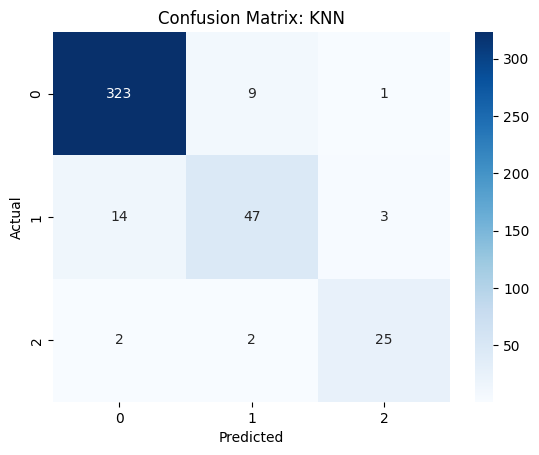

In [ ]:

plot_confusion_matrix(y_test, knn_preds, title="Confusion Matrix: KNN")


In [ ]:
# XGBoost Classifier

y_train_adj = (y_train.astype(int) - 1)
y_test_adj = (y_test.astype(int) - 1)

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_adj)
xgb_clf_preds = xgb_clf.predict(X_test_scaled)
print("Initial XGBoost Accuracy:", accuracy_score(y_test_adj, xgb_clf_preds))
print(classification_report(y_test_adj, xgb_clf_preds))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Initial XGBoost Accuracy: 0.960093896713615
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       333
           1       0.89      0.86      0.87        64
           2       0.94      1.00      0.97        29

    accuracy                           0.96       426
   macro avg       0.93      0.95      0.94       426
weighted avg       0.96      0.96      0.96       426



In [ ]:
# Cross-validation
cv_scores_xgb = cross_val_score(xgb_clf, X_train_scaled, y_train_adj, cv=5, scoring='accuracy')
print("CV Scores:", cv_scores_xgb)
print("Mean CV Score: {:.4f}".format(cv_scores_xgb.mean()))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CV Scores: [0.94705882 0.93823529 0.94117647 0.95       0.95882353]
Mean CV Score: 0.9471


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# GridSearchCV

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

gs_xgb = GridSearchCV(xgb_clf, xgb_param_grid, scoring='accuracy', cv=5)
gs_xgb.fit(X_train_scaled, y_train_adj)
print("Best XGB Params:", gs_xgb.best_params_)
print("Best XGB CV Score:", gs_xgb.best_score_)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:50:20] WARNING: /w

Best XGB Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best XGB CV Score: 0.9505882352941176


In [ ]:
# Fit model with best params on all training data
# Fit with best parameters
final_xgb = xgb.XGBClassifier(**gs_xgb.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_xgb.fit(X_train_scaled, y_train_adj)
xgb_preds = final_xgb.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test_adj, xgb_preds))
print("Classification Report:\n", classification_report(y_test_adj, xgb_preds))

Test Accuracy: 0.9507042253521126
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       333
           1       0.87      0.83      0.85        64
           2       0.93      0.97      0.95        29

    accuracy                           0.95       426
   macro avg       0.92      0.92      0.92       426
weighted avg       0.95      0.95      0.95       426



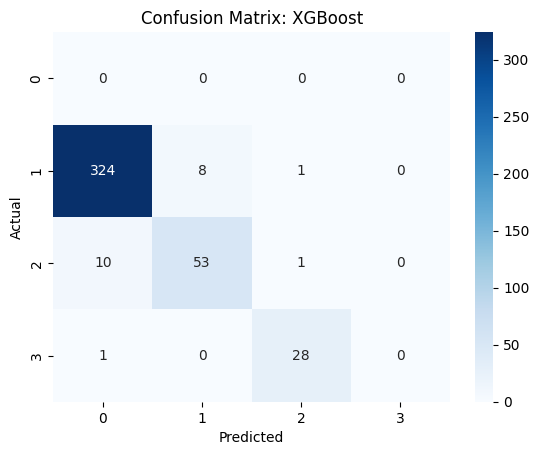

In [ ]:

# Confusion Matrix
plot_confusion_matrix(y_test, xgb_preds, title="Confusion Matrix: XGBoost")


In [ ]:
metrics = {
    "Model": ["Logistic Regression", "Random Forest", "K-Nearest Neighbors", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, logreg_init_preds),
        accuracy_score(y_test, rf_init_preds),
        accuracy_score(y_test, knn_init_preds),
        accuracy_score(y_test_adj,xgb_clf_preds)
    ],
    "F1 Score (weighted)": [
        f1_score(y_test, logreg_init_preds, average='weighted'),
        f1_score(y_test, rf_init_preds, average='weighted'),
        f1_score(y_test, knn_init_preds, average='weighted'),
        f1_score(y_test_adj, xgb_clf_preds, average='weighted')
    ],

}

In [ ]:
# Create DataFrame
results_df = pd.DataFrame(metrics)

# Display the results table
print(results_df)

                 Model  Accuracy  F1 Score (weighted)
0  Logistic Regression  0.880282             0.880964
1        Random Forest  0.953052             0.952496
2  K-Nearest Neighbors  0.915493             0.912794
3              XGBoost  0.960094             0.959874
